In [40]:
#step 1
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def unpickle(filepath):
    with open(filepath, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

def download_cifar10(data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
  
    all_data = []
    all_labels = []

    # Load training batches
    for filename in ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']:
        filepath = os.path.join(data_dir, filename)
        if os.path.exists(filepath):
            data_dict = unpickle(filepath)
            all_data.append(data_dict[b'data'])
            all_labels.extend(data_dict[b'labels'])
        else:
            print(f"File {filepath} does not exist.")
  
    # Load test batch
    filepath = os.path.join(data_dir, 'test_batch')
    if os.path.exists(filepath):
        data_dict = unpickle(filepath)
        test_data = data_dict[b'data']
        test_labels = data_dict[b'labels']
    else:
        print(f"File {filepath} does not exist.")

    # Save everything into a single dictionary
    combined_data = {
        'train_data': all_data,
        'train_labels': all_labels,
        'test_data': test_data,
        'test_labels': test_labels
    }
# convert to file pkl  best from csv 
    pickle.dump(combined_data, open('cifar10_combined.pkl', 'wb'))

if __name__ == '__main__':
    data_dir = '/kaggle/input/cifar10-python/cifar-10-batches-py'
    download_cifar10(data_dir)


In [ ]:
# clean data
# data cleaned

In [43]:
# Read about image histograms 
# צריך לבדוק מי מההיסטוגרמות הכי רחוקות וכו זה מה שיהוה אתגר באימון המודל בתכלס 

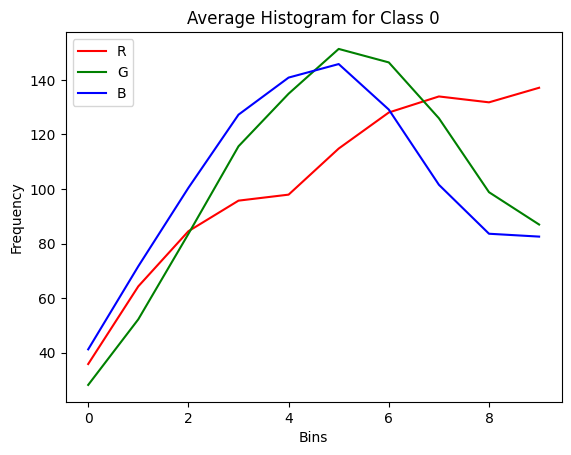

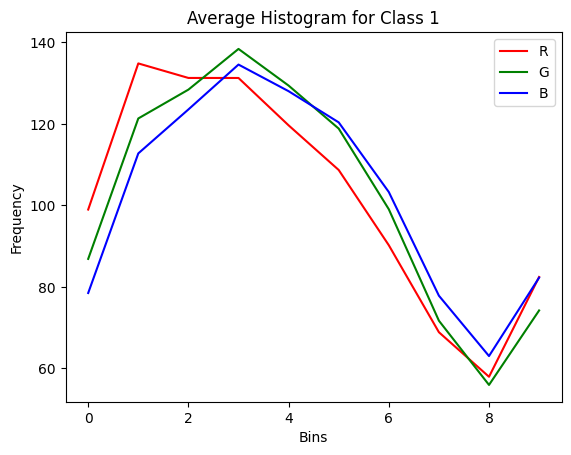

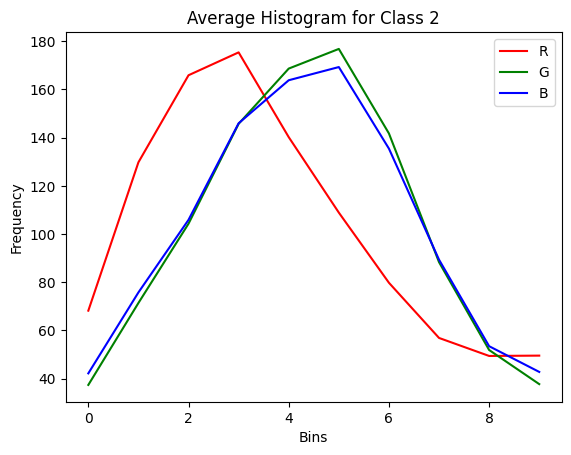

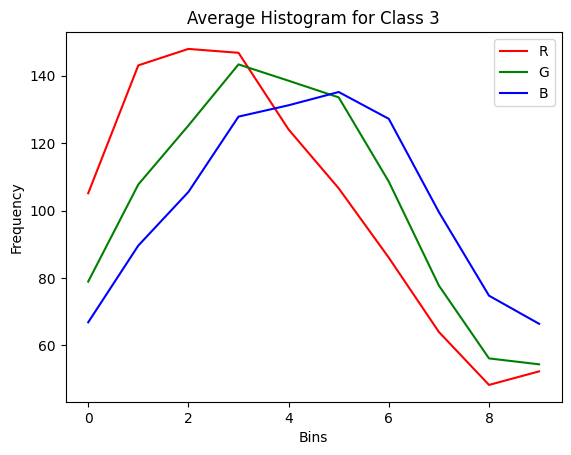

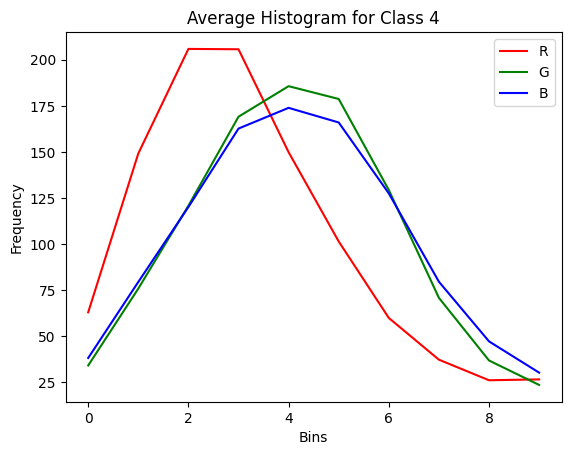

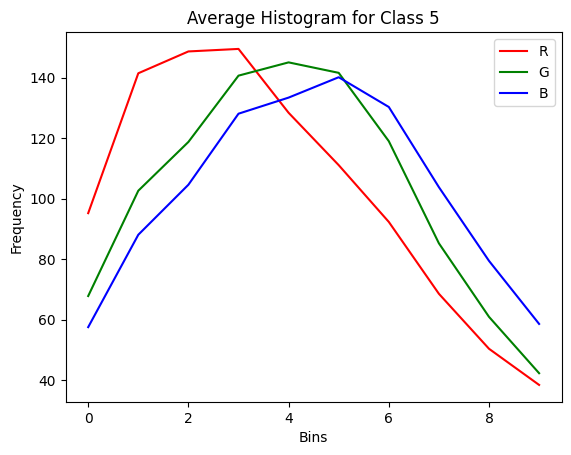

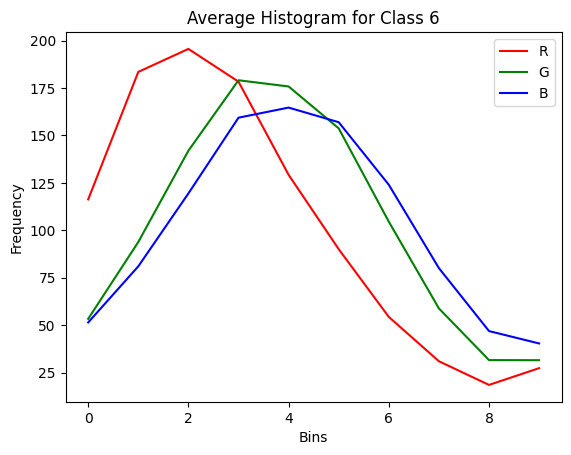

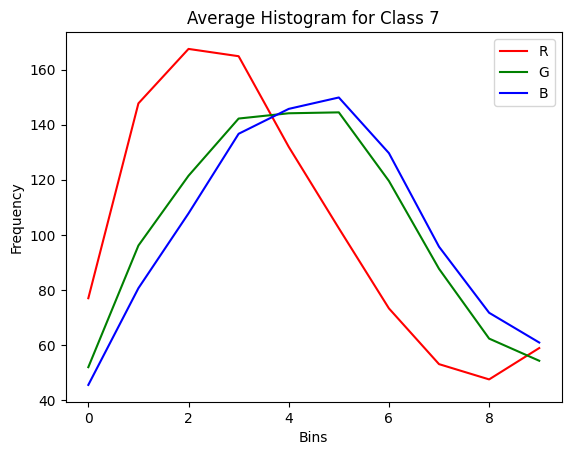

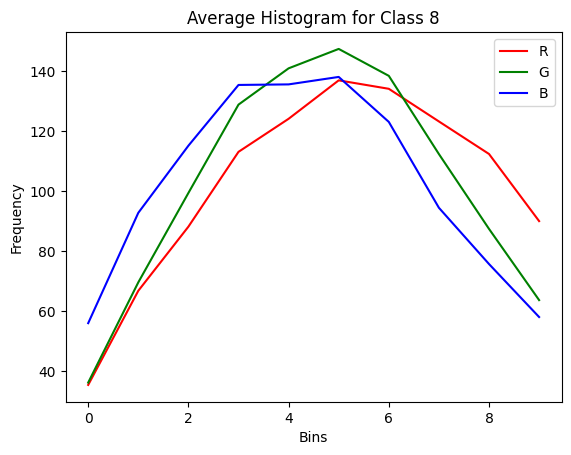

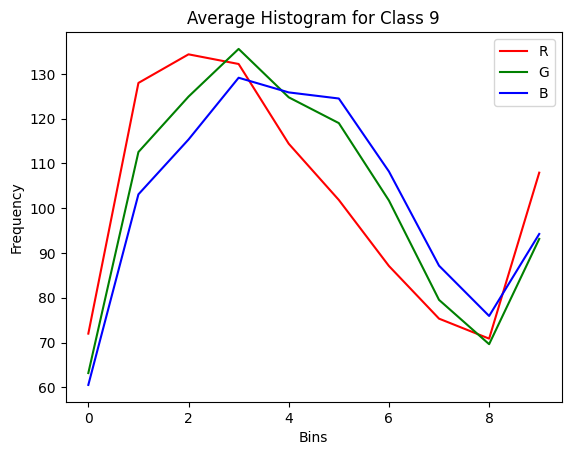

In [42]:
# Load the combined CIFAR-10 data
with open('cifar10_combined.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Extract training data and labels
train_data = np.concatenate(dataset['train_data'], axis=0).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(dataset['train_labels'])

# Initialize an empty list for each class to store histograms
histograms = {i: {'r': [], 'g': [], 'b': []} for i in range(10)}

# Calculate histograms
for i in range(len(train_data)):
    label = train_labels[i]
    img = train_data[i]
    
    for j, color in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([img], [j], None, [10], [0, 256])
        histograms[label][color].append(hist)

# Calculate average histograms and save them
average_histograms = {i: {'r': None, 'g': None, 'b': None} for i in range(10)}

for label, color_hists in histograms.items():
    for color in ['r', 'g', 'b']:
        average_histograms[label][color] = np.mean(color_hists[color], axis=0)

# Visualize average histograms for each class separately
for label, color_hists in average_histograms.items():
    plt.figure()
    for color in ['r', 'g', 'b']:
        plt.plot(color_hists[color], color=color, label=f"{color.upper()}")
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title(f'Average Histogram for Class {label}')
    plt.legend()
    plt.show()


In [12]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

# Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

# Assuming a validation set of 20% from the training set
val_size = int(0.2 * len(cifar10_train))
train_size = len(cifar10_train) - val_size

train_set, val_set = random_split(cifar10_train, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 35300165.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Step 3: Training self-made NN
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = F.relu(self.bn_conv2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = F.relu(self.bn_conv3(self.conv3(x)))
        x = F.relu(self.bn_conv4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.bn_dense1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_dense2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the device
net = Net().to(device)

# Output the number of parameters
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')


Number of trainable parameters: 18617482


In [23]:
import torch.optim as optim

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

# Placeholders for storing training history
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [] , []


In [24]:
# Training Loop
num_epochs = 140

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Training Loss and Accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    loss_hist.append(train_loss)
    acc_hist.append(train_acc)

    print(f"[Epoch {epoch+1}] Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    # Validation Loop
    net.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    loss_hist_val.append(val_loss)
    acc_hist_val.append(val_acc)

    print(f"[Epoch {epoch+1}] Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Update Learning Rate
    scheduler.step(val_loss)

print("Training complete.")


[Epoch 1] Training Loss: 1.7811, Training Accuracy: 36.04%
[Epoch 1] Validation Loss: 1.3962, Validation Accuracy: 49.42%
[Epoch 2] Training Loss: 1.4679, Training Accuracy: 47.09%
[Epoch 2] Validation Loss: 1.3206, Validation Accuracy: 52.15%
[Epoch 3] Training Loss: 1.3174, Training Accuracy: 53.13%
[Epoch 3] Validation Loss: 1.2249, Validation Accuracy: 57.00%
[Epoch 4] Training Loss: 1.1869, Training Accuracy: 58.20%
[Epoch 4] Validation Loss: 1.0571, Validation Accuracy: 62.13%
[Epoch 5] Training Loss: 1.0899, Training Accuracy: 61.87%
[Epoch 5] Validation Loss: 0.9546, Validation Accuracy: 66.13%
[Epoch 6] Training Loss: 1.0292, Training Accuracy: 64.25%
[Epoch 6] Validation Loss: 0.8599, Validation Accuracy: 70.33%
[Epoch 7] Training Loss: 0.9804, Training Accuracy: 66.28%
[Epoch 7] Validation Loss: 0.8466, Validation Accuracy: 70.77%
[Epoch 8] Training Loss: 0.9323, Training Accuracy: 67.89%
[Epoch 8] Validation Loss: 0.7938, Validation Accuracy: 72.72%
[Epoch 9] Training Loss:

In [25]:
# Save the trained model
torch.save(net.state_dict(), 'cifar10_model.pth')

In [5]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initialize the model and optimizer, then load the state
net = Net()
net.load_state_dict(torch.load('/kaggle/input/modelcifar10/cifar10_model.pth'))

<All keys matched successfully>

In [6]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def predict_image(image_path, model, class_names):
    """
    Predict the class of a single image.

    Parameters:
        image_path (str): The file path to the image.
        model (torch.nn.Module): The trained PyTorch model.
        class_names (list): The names of the classes.

    Returns:
        str: The name of the predicted class.
    """
    
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')  # Convert to RGB
    preprocess = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
    ])
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension

    # Move tensor to the same device as the model and make prediction
    img_tensor = img_tensor.to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
    _, predicted_idx = torch.max(output, 1)
    
    # Translate the index to the class name
    predicted_class = class_names[predicted_idx.item()]

    return predicted_class


In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [27]:
# Assume 'net' is your trained model
image_path = '/kaggle/input/frog-to-pred/Screenshot 2023-09-06 174957.png'
predicted_class = predict_image(image_path, net, class_names)
print(f'The image is predicted as: {predicted_class}')


The image is predicted as: frog


In [23]:
# Step 4: Try existing NN אמן עם רשת מאומנת מראש 
import torch.nn as nn
import torchvision.models as models
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet50, self).__init__()

        # Load the pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)
        
        # Remove the last fully connected layer to get the features
        modules = list(self.resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Add custom layers
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)  # Corrected this line
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_dense1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_dense2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the device
net = CustomResNet50().to(device)

# Output the number of parameters
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')


Number of trainable parameters: 26139210


In [24]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
loss_hist = []
acc_hist = []
loss_hist_val = []
acc_hist_val = []
import torch.optim as optim

# Create the model and move it to the device
net = CustomResNet50().to(device)

# Define the optimizer, criterion, scheduler, and history lists
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
loss_hist = []
acc_hist = []
loss_hist_val = []
acc_hist_val = []

# Training Loop
num_epochs = 140



In [25]:


for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Training Loss and Accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    loss_hist.append(train_loss)
    acc_hist.append(train_acc)

    print(f"[Epoch {epoch+1}] Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    # Validation Loop
    net.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    loss_hist_val.append(val_loss)
    acc_hist_val.append(val_acc)

    print(f"[Epoch {epoch+1}] Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Update Learning Rate
    scheduler.step(val_loss)

print("Training complete.")

[Epoch 1] Training Loss: 1.4906, Training Accuracy: 48.36%
[Epoch 1] Validation Loss: 1.5008, Validation Accuracy: 49.95%
[Epoch 2] Training Loss: 1.1667, Training Accuracy: 60.31%
[Epoch 2] Validation Loss: 1.0772, Validation Accuracy: 62.50%
[Epoch 3] Training Loss: 0.9970, Training Accuracy: 66.15%
[Epoch 3] Validation Loss: 0.8883, Validation Accuracy: 69.14%
[Epoch 4] Training Loss: 0.9153, Training Accuracy: 69.23%
[Epoch 4] Validation Loss: 0.9171, Validation Accuracy: 68.81%
[Epoch 5] Training Loss: 0.9429, Training Accuracy: 68.34%
[Epoch 5] Validation Loss: 1.0280, Validation Accuracy: 64.53%
[Epoch 6] Training Loss: 0.9244, Training Accuracy: 68.63%
[Epoch 6] Validation Loss: 0.8803, Validation Accuracy: 70.20%
[Epoch 7] Training Loss: 0.8191, Training Accuracy: 72.61%
[Epoch 7] Validation Loss: 0.7769, Validation Accuracy: 73.02%
[Epoch 8] Training Loss: 0.7638, Training Accuracy: 74.37%
[Epoch 8] Validation Loss: 0.8982, Validation Accuracy: 70.22%
[Epoch 9] Training Loss:

KeyboardInterrupt: 

In [ ]:
# Step 6: Transfer Learning (standard approach)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split

# Data preparation
data_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
val_size = int(0.2 * len(cifar10_train))
train_size = len(cifar10_train) - val_size
train_set, val_set = random_split(cifar10_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Setting up the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace and enable gradient for the final layer
number_of_features = model.fc.in_features
model.fc = nn.Linear(number_of_features, 10)
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)  # Ensure the entire model is on the same device

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

# Training loop
num_epochs = 140
transfer_loss_hist = []
transfer_acc_hist = []
transfer_loss_hist_val = []
transfer_acc_hist_val = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    transfer_loss_hist.append(train_loss)
    transfer_acc_hist.append(train_acc)

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    transfer_loss_hist_val.append(val_loss)
    transfer_acc_hist_val.append(val_acc)

    # Print the statistics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-----------------------------")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    print("-----------------------------\n")

    scheduler.step(val_loss)

print("Training complete.")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/140
-----------------------------
Train Loss: 1.8043, Train Acc: 37.16%
Validation Loss: 1.6801, Validation Acc: 42.50%
-----------------------------

Epoch 2/140
-----------------------------
Train Loss: 1.6750, Train Acc: 42.19%
Validation Loss: 1.6513, Validation Acc: 44.06%
-----------------------------

Epoch 3/140
-----------------------------
Train Loss: 1.6438, Train Acc: 43.23%
Validation Loss: 1.6320, Validation Acc: 44.79%
-----------------------------

Epoch 4/140
-----------------------------
Train Loss: 1.6250, Train Acc: 43.87%
Validation Loss: 1.6538, Validation Acc: 44.92%
-----------------------------

Epoch 5/140
-----------------------------
Train Loss: 1.6177, Train Acc: 44.26%
Validation Loss: 1.5875, Validation Acc: 45.52%
-----------------------------

Epoch 6/140
-----------------------------
Train Loss: 1.6090, Train Acc: 44.53%
Validation Loss: 1.6634, Validation Acc: 44.66%
-

KeyboardInterrupt: 

In [ ]:
# with facke data 

In [45]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split

# Data preparation
# Data preparation
data_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),  # Added Vertical Flip
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),  # Added Random Grayscale
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Added Random Perspective
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])  # CIFAR-10 normalization
])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
val_size = int(0.2 * len(cifar10_train))
train_size = len(cifar10_train) - val_size
train_set, val_set = random_split(cifar10_train, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Setting up the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace and enable gradient for the final layer with dropout
number_of_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(number_of_features, 10)
)

model = model.to(device)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.01569854, weight_decay=0.00016544)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 140

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    # Print the statistics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-----------------------------")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    print("-----------------------------\n")

    scheduler.step(val_loss)

print("Training complete.")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/140
-----------------------------
Train Loss: 6.9137, Train Acc: 18.11%
Validation Loss: 6.8204, Validation Acc: 20.83%
-----------------------------

Epoch 2/140
-----------------------------
Train Loss: 7.9256, Train Acc: 18.77%
Validation Loss: 5.9343, Validation Acc: 23.14%
-----------------------------

Epoch 3/140
-----------------------------
Train Loss: 8.1158, Train Acc: 18.80%
Validation Loss: 6.8235, Validation Acc: 19.48%
-----------------------------

Epoch 4/140
-----------------------------
Train Loss: 8.1801, Train Acc: 18.77%
Validation Loss: 5.3866, Validation Acc: 23.17%
-----------------------------

Epoch 5/140
-----------------------------
Train Loss: 8.2061, Train Acc: 19.09%
Validation Loss: 5.4128, Validation Acc: 23.96%
-----------------------------

Epoch 6/140
-----------------------------
Train Loss: 8.1257, Train Acc: 19.09%
Validation Loss: 6.7276, Validation Acc: 21.70%
-

KeyboardInterrupt: 

In [ ]:
# MLFLOW

In [ ]:
# Entropy

In [ ]:
# UI